# Препроцессинг

## Импорт всего необходимого в ходе работы с данными.

Использованы версии пакетов, доступные в AnacondaNavigator на 15.04.2020

В числе прочего pandas - средство работы с таблицами типа .csv(sep = ',');

numpy - пакет для эффективной работы с матрицами и веторами;

модуль pyplot - построение графических иллюстраций в теле кода;

некоторые модули пакета scipy, используемые для построения специального SVD разложения (использовал вместо numpy.linalg.svd в силу личных предпочтений).

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp
import itertools
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore") # отключает предупреждения


# Python Stargazer can be used for OLS-models only :c

In [3]:
'''

Определим функцию, обрабатывающие типичный файл из базы данных NES.

Определим функцию, применяющую фунцию обработки к нескольким
файлам и скрепляющую их в требуемый для дальнейших вычислений формат.

'''

def preprocess(file_string): 
    
    # считываем из директории
    data = pd.read_csv(file_string)
    # оставляем только Москву и МО
    data_msc = data[data['Reg'] == 1145]
    data_mo = data[data['Reg'] == 1146]
    data = pd.concat([data_msc,data_mo])
    del data['Reg']
    
    # все причины

    data = data[data['Cause'] == 0]
    del data['Cause']
    del data['CCl']
    data = data[data['Year']>=1993]
        
    
    # разбиваем по полу
    
    data_male = data[data['Sex'] == 'M']
    data_female = data[data['Sex'] == 'F']
    
    # только городское население
    data_male = data_male[data_male['Group'] == 'T']
    data_female = data_female[data_female['Group'] == 'T']

    data_male = data_male.groupby(data_male['Year']).sum()/2
    data_female = data_female.groupby(data_female['Year']).sum()/2
    
    # mortality age profiles typical overview
    data_male = data_male.T
    data_female = data_female.T
    
    data_male = data_male[:18]
    data_female = data_female[:18]
    
    return data_male, data_female

'''

Примечание: не берем данные раньше 1998 года - так себе качество, добавляет неадекватное количество шума.

''' 

def preprocess_mortality():
    print('3 mortality files preprocessing...')
    print(' ')
    males1989,females1989 = preprocess('DRc5a1989-1998.txt')
    males1999,females1999 = preprocess('DRc5a1999-2005.txt')
    males2006,females2006 = preprocess('DRc5a2006-2012.txt')
    #males2013,females2013 = preprocess('mort_test_2011-2014.txt')
    
    
    #del males2013[2011]
    #del males2013[2012]
    #del females2013[2011]
    #del females2013[2012]


    print('Datasets concatenating...')
    print(' ')
    data_male = pd.concat([males1989,males1999,males2006], axis = 1) #,males2013 
    data_female = pd.concat([females1989,females1999,females2006], axis = 1) #,females2013 
    
    print('Process finished successfully.')
    print(' ')
    return data_male, data_female

In [4]:
data_male, data_female = preprocess_mortality()

3 mortality files preprocessing...
 
Datasets concatenating...
 
Process finished successfully.
 


In [5]:
'''

Взглянем на то, что получилось (лишь на шапку)

Данные в таблице, согласно описанию Базы Данных РЭШ, рассчитаны на 1 000 000 человек

'''


data_male

Year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Drac0,17566.0,19690.0,18020.5,16802.5,16822.0,16226.5,16213.0,14753.0,15244.5,14344.0,13671.0,11638.5,10585.5,9132.5,9004.5,8051.0,8405.5,8118.5,7412.0,8898.5
Drac1,784.5,857.0,823.5,748.0,673.5,720.0,723.0,628.0,745.0,698.5,642.5,632.5,560.5,634.5,540.0,483.0,412.0,475.0,447.5,372.0
Drac5,539.0,584.5,567.5,506.0,437.5,422.5,519.0,495.0,423.0,319.5,421.5,366.0,300.5,314.5,249.0,236.0,260.0,224.0,204.5,217.5
Drac10,623.5,551.0,575.5,467.0,463.5,429.5,494.5,452.5,448.5,443.5,478.5,397.5,491.5,398.5,401.0,352.0,316.0,280.0,272.5,276.5
Drac15,1926.5,2108.0,2306.0,1850.0,1659.0,1721.0,1661.5,1651.0,1494.5,1429.5,1311.5,1280.5,1165.0,1160.0,1224.0,1191.5,976.0,867.5,805.0,937.5
Drac20,3435.0,3819.0,4197.0,3716.0,3518.5,3879.0,4176.5,4341.5,3428.5,3006.0,2891.5,3144.5,3054.0,2928.5,2715.5,2373.5,2023.0,1939.0,1755.0,1719.5
Drac25,4662.5,5577.0,5800.5,4812.5,4162.5,4395.0,4948.0,5458.0,5158.5,4769.0,4894.5,4936.5,5326.5,5587.5,5134.0,4798.5,4132.0,3880.0,3288.5,3341.0
Drac30,6812.5,8040.5,7924.0,6413.0,5036.5,5028.5,5731.5,5743.0,6020.5,6300.5,5979.5,6149.0,6399.5,6441.5,6667.0,6466.0,6124.5,5770.0,5174.0,5385.5
Drac35,9589.0,11663.0,11280.0,8292.0,6569.5,6402.0,6792.5,7357.0,8043.5,7969.0,7831.0,7575.0,7413.5,7107.5,6694.5,6663.5,6268.5,6321.5,5941.5,6164.5
Drac40,14438.0,17493.0,16678.5,12230.5,9407.5,9232.5,9960.0,10502.5,11285.0,11271.0,11317.0,10810.0,10260.5,9590.5,9081.0,8758.0,7922.5,7320.0,6774.5,6576.0


In [6]:
'''
Логарифмируем все элементы обоих датасетов

За основу взята модель Ли-Картера, с некоторыми отклонениями от канона, дальше подробнее

Оставляем логарифмы как посчитались во избежание потерь лишних знаков, 
numpy считает их более чем хорошо, а момент важный

'''

data_male = data_male.apply(lambda x: np.log(x))

data_female = data_female.apply(lambda x: np.log(x))

In [7]:
data_male.head()

Year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Drac0,9.773720,9.887866,9.799265,9.729283,9.730443,9.694401,9.693569,9.599202,9.631974,9.571087,9.523032,9.362074,9.267240,9.119595,9.105480,8.993552,9.036642,9.001901,8.910856,9.093638
Drac1,6.665047,6.753438,6.713564,6.617403,6.512488,6.579251,6.583409,6.442540,6.613384,6.548935,6.465367,6.449680,6.328829,6.452837,6.291569,6.180017,6.021023,6.163315,6.103677,5.918894
Drac5,6.289716,6.370757,6.341241,6.226537,6.081077,6.046189,6.251904,6.204558,6.047372,5.766757,6.043820,5.902633,5.705448,5.750984,5.517453,5.463832,5.560682,5.411646,5.320568,5.382199
Drac10,6.435349,6.311735,6.355239,6.146329,6.138806,6.062622,6.203547,6.114788,6.105909,6.094698,6.170656,5.985195,6.197462,5.987707,5.993961,5.863631,5.755742,5.634790,5.607639,5.622211
Drac15,7.563460,7.653495,7.743270,7.522941,7.413970,7.450661,7.415476,7.409136,7.309547,7.265080,7.178927,7.155006,7.060476,7.056175,7.109879,7.082968,6.883463,6.765616,6.690842,6.843217


In [8]:
from copy import copy

'''
Центрируем на средние по возрастной группе.

В работе [*] описаны и некоторые преимущества над классической процедурой Ли-Картера другого алгоритма, построенного на случайном блуждании.

Можно легко совместить преимущества обоих подходов, используя не сквозные средние, а скользящие. В частности, с шириной окна 1 в качестве тривиалього бейслайна.

'''
vec_of_means_male = []
for i in range(len(data_male)):
    mean = np.round(np.mean(data_male.iloc[i]),3)
    vec_of_means_male.append(mean)
    
print(' ')
print('Центрирующий вектор для мужчин: ', vec_of_means_male)

'''
Дублируем процедуру для женской таблицы
'''

vec_of_means_female = []
for i in range(len(data_female)):
    mean = np.round(np.mean(data_female.iloc[i]),3)
    vec_of_means_female.append(mean)
    
print(' ')
print('Центрирующий вектор для женщин: ', vec_of_means_female)

data_female_centered = copy(data_female)
for i in range(len(data_female)):
    data_female_centered.iloc[i] = data_female_centered.iloc[i] - vec_of_means_female[i]

 
Центрирующий вектор для мужчин:  [9.426, 6.42, 5.884, 6.039, 7.229, 8.003, 8.455, 8.721, 8.917, 9.23, 9.562, 9.896, 10.184, 10.509, 10.797, 11.106, 11.438, 11.783]
 
Центрирующий вектор для женщин:  [9.146, 6.196, 5.519, 5.556, 6.426, 6.744, 7.077, 7.381, 7.66, 8.016, 8.386, 8.751, 9.111, 9.491, 9.935, 10.452, 11.0, 11.54]


In [9]:
'''
Работаем с копией датасета, чтобы не изменить исходный объект в памяти.

Создаем копию и центрируем ее, вычитая из каждой строки поэлементно соответствующую координату вектора средних.

Для женского датасета дублируем процедуру.

'''
from copy import copy


data_male_centered = copy(data_male)

for i in range(len(data_male)):
    data_male_centered.iloc[i] = data_male_centered.iloc[i] - vec_of_means_male[i]
    
data_female_centered = copy(data_female)

for i in range(len(data_female)):
    data_female_centered.iloc[i] = data_female_centered.iloc[i] - vec_of_means_female[i]

# Немного посмотрим на то, что у нас пока что получилось.

## Посмотрим на средний возрастной профиль для мужчин и женщин.

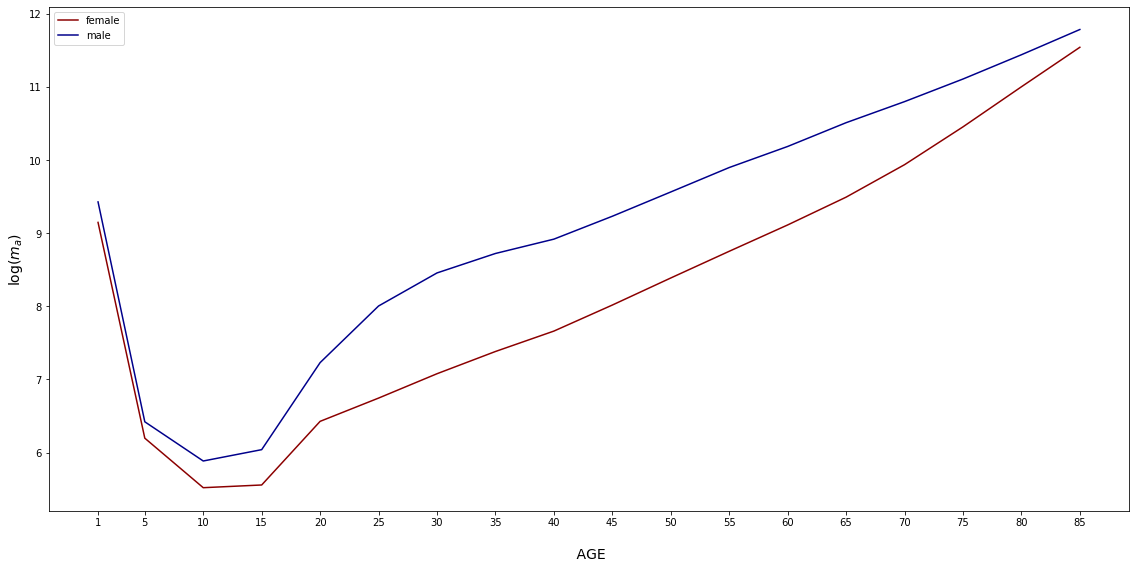

In [10]:
fig = plt.figure(figsize = (15,7))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
         vec_of_means_female,
         color = 'darkred',
         label = 'female')

plt.plot([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
         vec_of_means_male,
         color = 'darkblue',
         label = 'male')

plt.xticks([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])

ax.set_xlabel('\n AGE',fontsize = 14)
ax.set_ylabel('log($m_a$)',fontsize = 14)
#ax.set_title('\n Средние возрастные профили логарифмированных коэффициентов смертности \n для мужчин и женщин, Москва и МО, период 1993-2012 \n', fontsize = 14)
plt.legend();
plt.savefig('Средние профили.png')
plt.show()



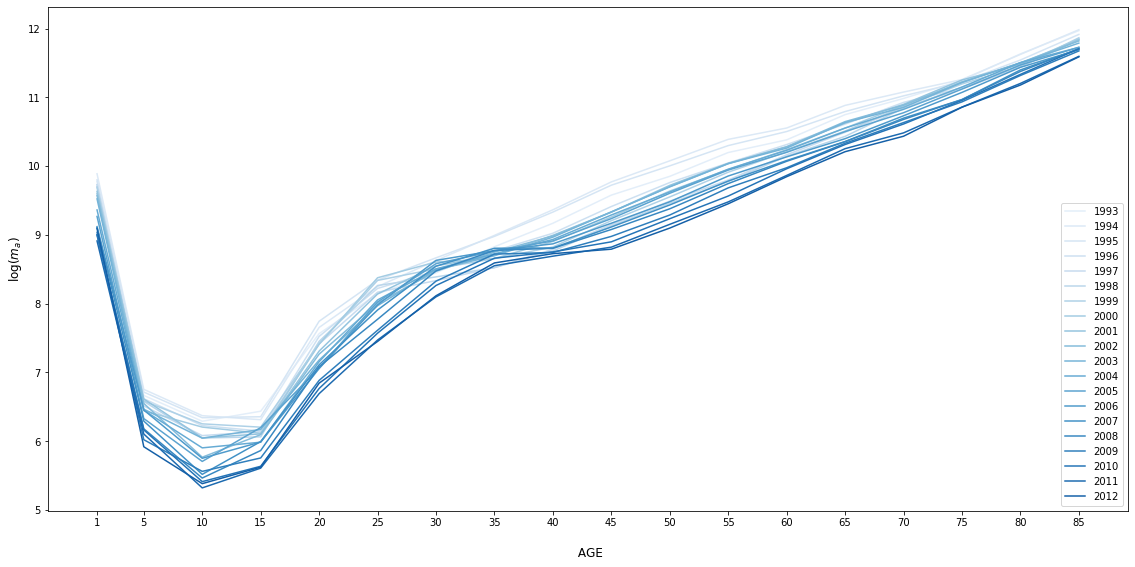

In [11]:
import cycler

n = 24
color = plt.cm.Blues(np.linspace(0.1, 1,n+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig = plt.figure(figsize = (15,7))
ax = fig.add_axes([0, 0, 1, 1])


plt.plot(colormap = 'Blues')
for year in data_male.columns:
    plt.plot([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
             data_male[year],
             label = year)
    

plt.xticks([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
ax.set_xlabel('\n AGE',fontsize = 12)
ax.set_ylabel('log($m_a$)',fontsize = 12)
#ax.set_title('\n Возрастные профили коэффициентов смертности \n для мужчин, Москва и МО, период 1993-2014 \n', fontsize = 14)
plt.savefig('Динамика профилей.png')
plt.legend();





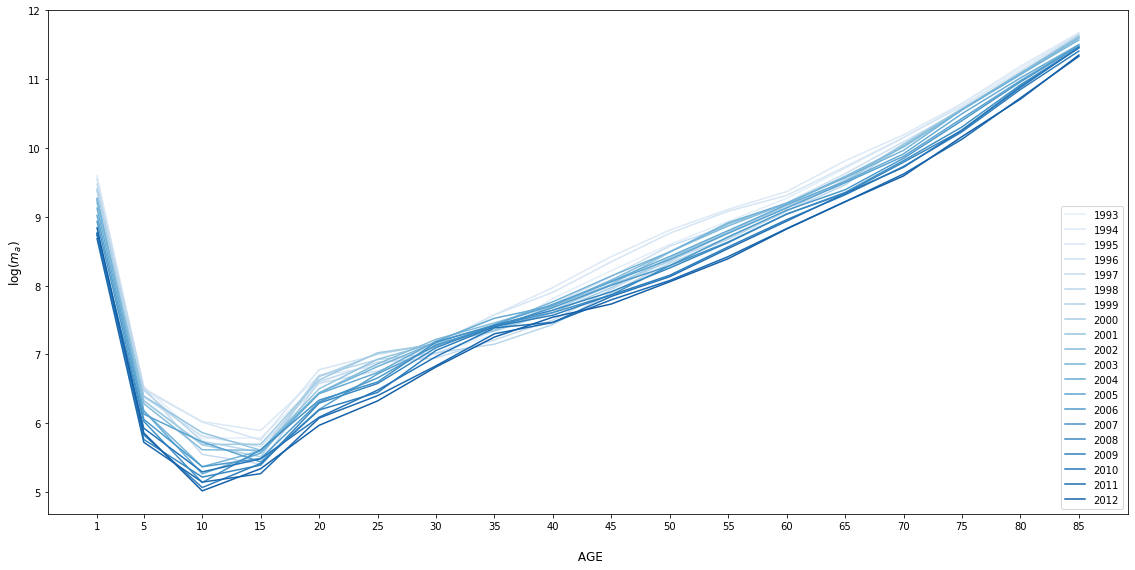

In [12]:
color = plt.cm.Blues(np.linspace(0.1, 1,n+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig = plt.figure(figsize = (15,7))
ax = fig.add_axes([0, 0, 1, 1])


plt.plot(colormap = 'Blues')
for year in data_male.columns:
    plt.plot([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
             data_female[year],
             label = year)
    

plt.xticks([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
ax.set_xlabel('\n AGE',fontsize = 12)
ax.set_ylabel('log($m_a$)',fontsize = 12)
#ax.set_title('\n Возрастные профили коэффициентов смертности \n для женщин, Москва и МО, период 1993-2014 \n', fontsize = 14)

plt.legend();




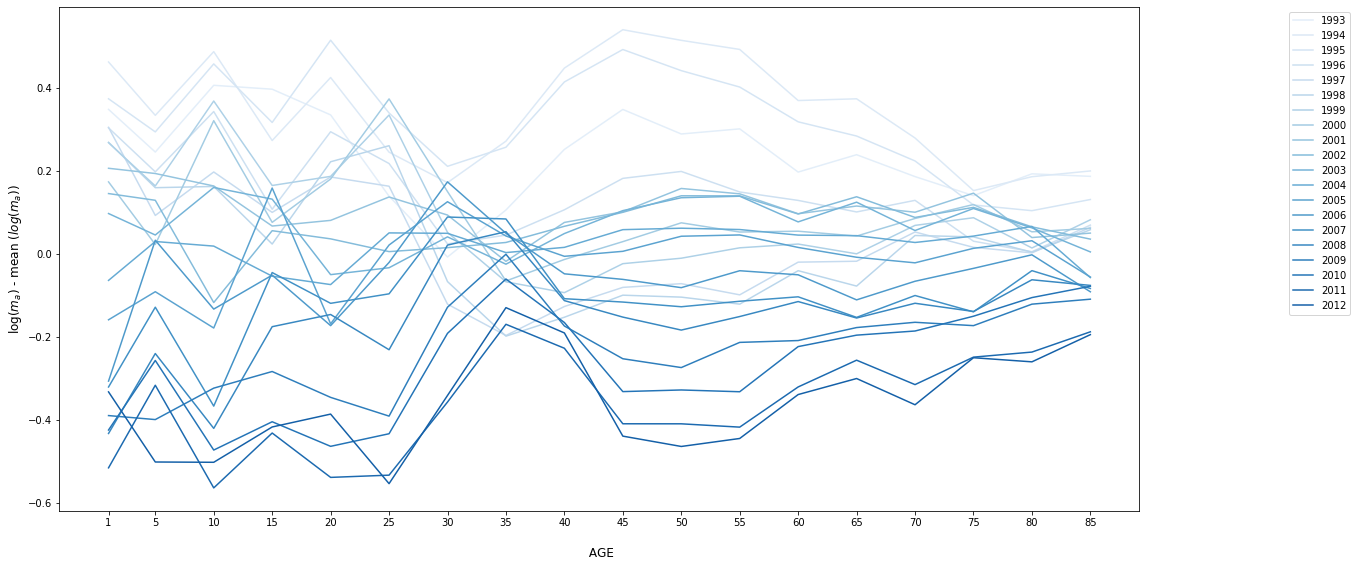

In [13]:
n = 24
color = plt.cm.Blues(np.linspace(0.1, 1,n+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig = plt.figure(figsize = (15,7))
ax = fig.add_axes([0, 0, 1, 1])


plt.plot(colormap = 'Blues')
for year in data_male.columns:
    plt.plot([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
             data_male_centered[year],
             label = year)
    

plt.xticks([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
ax.set_xlabel('\n AGE',fontsize = 12)
ax.set_ylabel('log($m_a$) - mean ($log(m_a$))',fontsize = 12)
#ax.set_title('\n Возрастные профили отклонений от среднего профиля \n для мужчин, Москва и МО, период 1993-2009 \n', fontsize = 14)

leg = plt.legend()
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = 0.2
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)





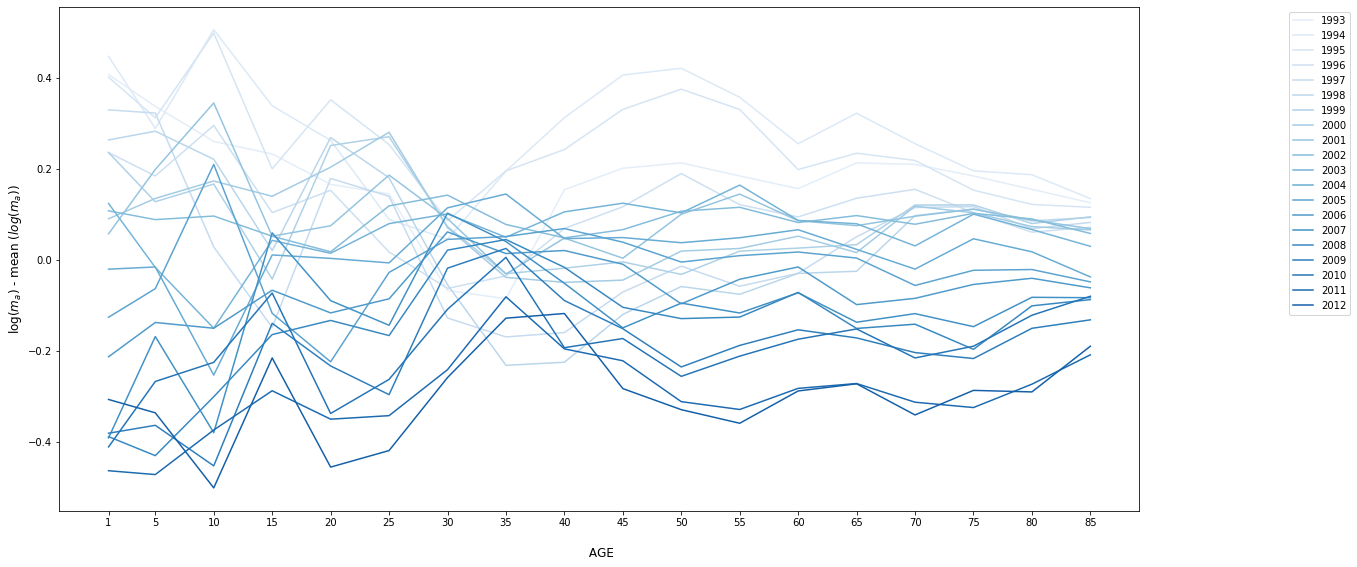

In [14]:
import cycler
color = plt.cm.Blues(np.linspace(0.1, 1,n+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig = plt.figure(figsize = (15,7))
ax = fig.add_axes([0, 0, 1, 1])


plt.plot(colormap = 'Blues')
for year in data_male.columns:
    plt.plot([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
             data_female_centered[year],
             label = year)
    

plt.xticks([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
ax.set_xlabel('\n AGE',fontsize = 12)
ax.set_ylabel('log($m_a$) - mean ($log(m_a$))',fontsize = 12)
#ax.set_title('\n Возрастные профили отклонений от среднего профиля \n для женщин, Москва и МО, период 1993-2009 \n', fontsize = 14)



leg = plt.legend()
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = 0.2
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)



### Про динамику

Наиболее тривиальный подход к прогнозированию - использовать какую-либо экстраполяцию первого порядка, например, средним или последним значением.

Однако видно, что даже в течение 10 лет происходят видимые изменения в структуре отклонений от среднего. Нам хотелось бы учесть такое поведение и скорректировать на него наш прогноз.
Интуитивно можно предположить, что изменения происходят под влиянием:

1) эффекта конкретного года

2) эффекта рассматриваемой возрастной группы, например, группа 35-40 во времени явно стабильнее с точки зрения отклонений, нежели более старые группы или дети.


Необходимо выделить основные компоненты, отвечающие за подобную динамику, причем хотелось бы, чтобы полученные оценки обладали набором "хороших", со статистической точки зрения, свойств.

Для подобной оценки мы будем использовать модель из семейства Ли-Картера, основанную на малоранговой аппроксимации псевдо-плотных матриц.

### SVD - разложение для псевдно-плотной матрицы (пока работаем с мужчинами)

In [15]:
X = np.array(data_male_centered)

In [16]:
X.shape

(18, 20)

# Прогнозирование

Lee-Carter полагают коэффициенты $\beta$ постоянными во времени. Необходимо подобрать неплохую модель для рядов $\gamma$. Конвенционально использую RW с дрифтом (например, в силу нестационарности).

In [17]:
B,L,Uh = np.linalg.svd(X,full_matrices=False)

In [18]:
G = np.diag(L)@Uh

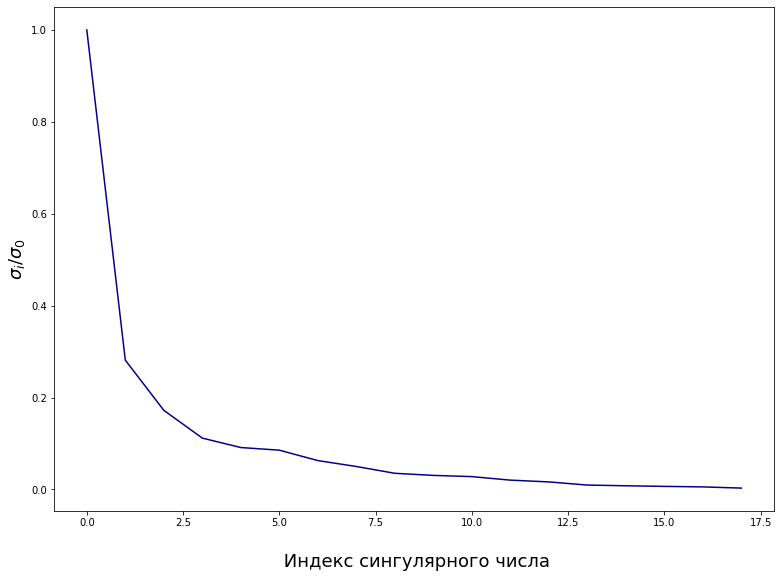

In [19]:
fig = plt.figure(figsize = (10,7))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(L/ L[0],color = 'darkblue')

ax.set_xlabel('\n Индекс сингулярного числа',fontsize = 18)
ax.set_ylabel('$\sigma_i / \sigma_0$',fontsize = 18)
plt.savefig('Сингулярные числа.png')

In [20]:
'''
достаточно правдподобно

'''


def create_k_beta_vector(k,B = B):
    return B[:,k].reshape(-1,1)


def create_k_kappa_vector(k,G = G):
    return G[k].reshape(1,-1)

def create_k_principal(k,B = B, G = G):
    beta_k = create_k_beta_vector(k)
    kappa_k = create_k_kappa_vector(k)
    return beta_k@kappa_k

In [21]:
'''
создаем аппроксимацию первыми k одноранговыми компонентами
'''

def create_approx_k(k):
    M = np.zeros((X.shape[0],X.shape[1]))
    for i in range(k):
        M += create_k_principal(i)
    return M



In [22]:
M = create_approx_k(1)
np.linalg.norm(M-X)

1.5073988632352313

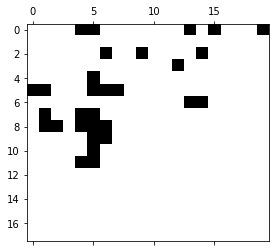

In [23]:
plt.spy(X-M,precision = 0.15); ## какие места пробиваются аппроксимацией хуже всего? предположительно младшая и старшая группы в местах выбросов

In [24]:
'''
Далее, согласно Ли-Картеру, мы предполагаем постоянство бет во времени, однако должны проверить выполнение условий на оцененные параметры.

Все выполнено с точностью до ошибки хранения в памяти. В случае, если вдруг не выполнено, можно воспользоваться преобразованиями, описанными в теле работы.
'''

kappa_0 = create_k_kappa_vector(0)
beta_0 = create_k_beta_vector(0)

print('Сумма капп равна: {}'.format(round(kappa_0.sum(),1))) # т.е. условие выполнено

print('Норма вектора'+ ' beta ' +'равна: {}'.format(round(np.linalg.norm(beta_0),6)))

Сумма капп равна: -0.0
Норма вектора beta равна: 1.0


In [25]:
'''
ТУТ УПРАВЛЕНИЕ ПАРАМЕТРОМ АППРОКСИМАЦИИ
'''

KAPPA = list()
for i in range(2):
    KAPPA.append(create_k_kappa_vector(i))

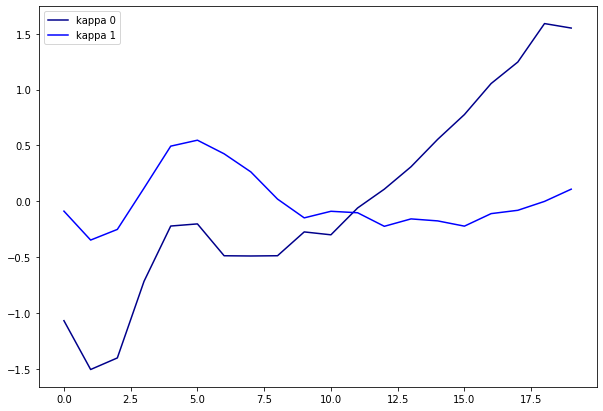

In [26]:
colors = ['darkblue','blue','lightblue','grey']
plt.figure(figsize = (10,7))
rng = range(4)
i = 0
for elems in KAPPA:
    plt.plot(elems.reshape(-1,1),label = 'kappa ' + str(i),color = colors[i])
    i +=1
plt.legend();


Далее необходимо достаточно хорошо предсказать фиксированный временной эффект для каждого из выбранного нами ряда Капп.

Для каждого ряда в отдельности подберем наиболее правдопобную модель из семейства ARIMA, используя критерий Акаике, в основе которого лежить дивергенция Кульбака-Лейблера

Очевидна нестационарность каппы-ноль, как это и должно быть, учитывая относительную монотонность в смещении профилей во времени, там мы ожидаем ненулевой порядок интегрированности ряда.

На остальные надо смотреть. Понятно, что при такой мизерной длине ряда все тесты будут выглядеть весьма сомнительно, однако с расширением доступных датасетов устойчивость будет расти.



Научимся подбирать по ряду капп автоматическую ариму (SARIMA в пакете statmodels), очевидно, в случае нестационарного ряда оптимальной окажется арима с ненулевым порядком интегрированности.

### Пример разложения профиля

In [27]:
BETAS = []

for i in range(len(KAPPA)):
    BETAS.append(np.array(create_k_beta_vector(i)))

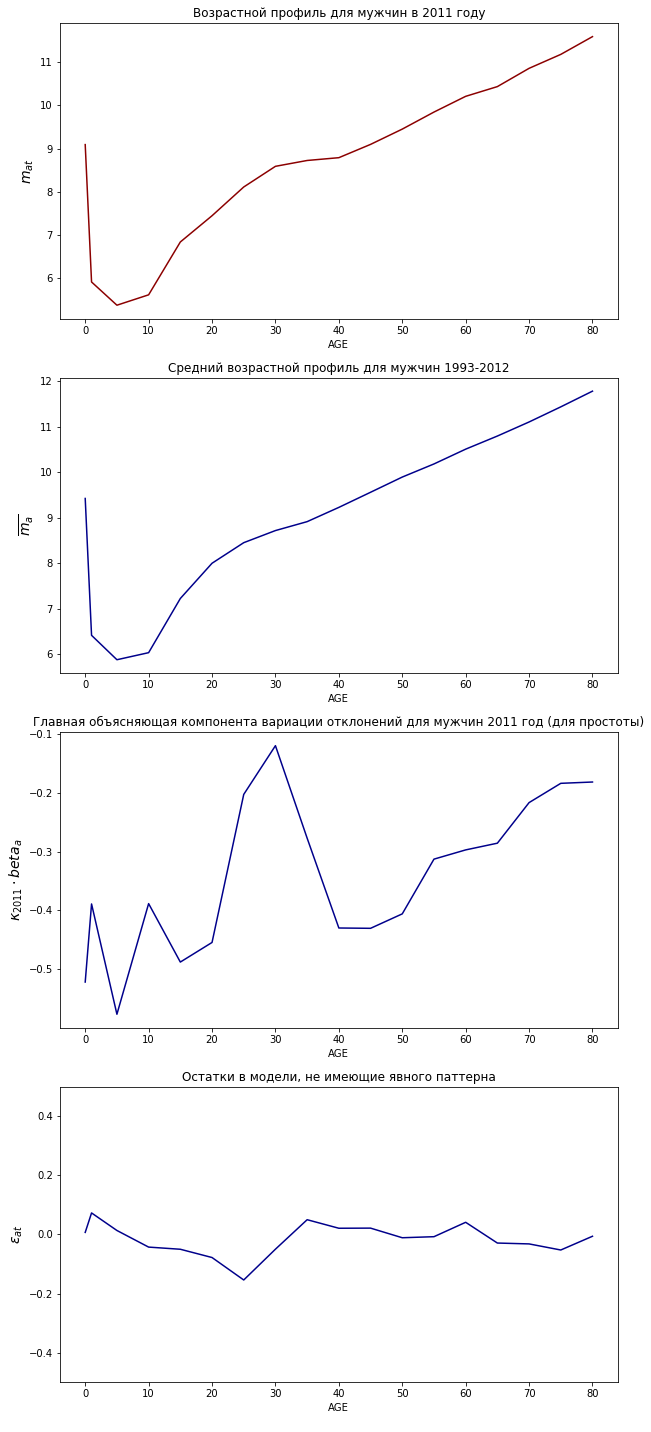

In [28]:
n = 20
color = plt.cm.Blues(np.linspace(0.1, 1,n+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize = (10,25))
#plt.setp(ax1, xticks=list(range(0,80,5)),xlim = [-5,80])
arg = [0,1] + list(range(5,85,5))


ax1.plot(arg,data_male[2012],color = 'darkred')
    
ax2.plot(arg,np.array(vec_of_means_male),color = 'darkblue')
ax3.plot(arg,BETAS[0]*KAPPA[0][0][-1],color = 'darkblue')

plt.setp(ax4,ylim = [-0.5,0.5])


residuals = np.array(data_male[2011]).reshape(-1,1) - (np.array(vec_of_means_male).reshape(-1,1) + BETAS[0]*KAPPA[0][0][-1])
ax4.plot(arg,residuals,color = 'darkblue')

ax1.set_title('Возрастной профиль для мужчин в 2011 году')
ax2.set_title('Средний возрастной профиль для мужчин 1993-2012')
ax3.set_title('Главная объясняющая компонента вариации отклонений для мужчин 2011 год (для простоты)')
ax4.set_title('Остатки в модели, не имеющие явного паттерна')

for ax in (ax1,ax2,ax3,ax4):
    ax.set_xlabel('AGE\n')
    
ax1.set_ylabel('$m_{at}$',fontsize = 14)
ax2.set_ylabel('$\overline{m_a}$',fontsize = 14)
ax3.set_ylabel('$\kappa_{2011}\cdot beta_{a}$',fontsize = 14)
ax4.set_ylabel('$\epsilon_{at}$',fontsize = 14)

plt.savefig('123.png')
plt.show()

### FORECASTING

Дело за малым: осталось спрогнозировать ряд капп, а затем построить прогноз в явном виде. 

Авторы статьи используют для моделирования RW with drift, автоподбор (делал в R, в питоне не очень удобно) выдал лучшую с т.з. криетрия Акаике ARIMA(0,1,0)

Модель имеет вид:

$$\kappa_t = \kappa_{t-1} + \theta +\epsilon$$

MLE - оценка для $\theta$ имеет вид:

$$ \hat{\theta} = \dfrac{\kappa_T - \kappa_0}{T - 1}$$

Пдтвердим тестом на значимость.

In [29]:
y = KAPPA[0][0]
best_model = sm.tsa.statespace.SARIMAX(y, order = (0,1,0)).fit(disp=-1)
print(best_model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &        y         & \textbf{  No. Observations:  } &     20      \\
\textbf{Model:}                  & SARIMAX(0, 1, 0) & \textbf{  Log Likelihood     } &   -2.915    \\
\textbf{Date:}                   & Fri, 08 May 2020 & \textbf{  AIC                } &   7.830     \\
\textbf{Time:}                   &     09:55:54     & \textbf{  BIC                } &   8.775     \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } &   7.990     \\
\textbf{}                        &       - 20       & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{sigma2} &       0.0796  &        0.026     &     3.065  &         0.002        &        0.029    &        0.130     \\
\bottomrule
\end{tabular}
\be

In [30]:
def compute_theta(row):
    return (row[-1] - row[0])/len(row)

In [31]:
def forecast_kappa(row,n_steps = 1):
    for i in range(n_steps):
        theta = compute_theta(row)
        frc = row[-1] + theta
        row = np.append(row,frc)
    return row

In [32]:
def return_initial_values_of_forecast(n_steps = 1): ## counted per million of population
    f =np.array(vec_of_means_male).reshape(-1,1) + forecast_kappa(y,n_steps = n_steps)[-1]*BETAS[0]
    return f

frc2013 = np.round(np.exp(return_initial_values_of_forecast(n_steps = 1)))

### Посмотрим на качество

In [35]:
a,b = preprocess('mort_test_2011-2014.txt')
a = pd.DataFrame(a)
del a[2012]
del a[2014]
del a[2011]

a['forecast2013'] = frc2013

In [36]:
a

Year,2013,forecast2013
Drac0,7881.5,7043.0
Drac1,380.5,403.0
Drac5,204.0,192.0
Drac10,252.5,275.0
Drac15,894.5,812.0
Drac20,1761.0,1826.0
Drac25,3317.0,3771.0
Drac30,5454.0,5383.0
Drac35,6397.5,5521.0
Drac40,6412.5,6397.0


In [33]:
# средний модуль отклонения

np.sum(np.abs((np.array(a[2013]) - np.array(a['forecast2013']))))/len(a[2013])

1222.9722222222222

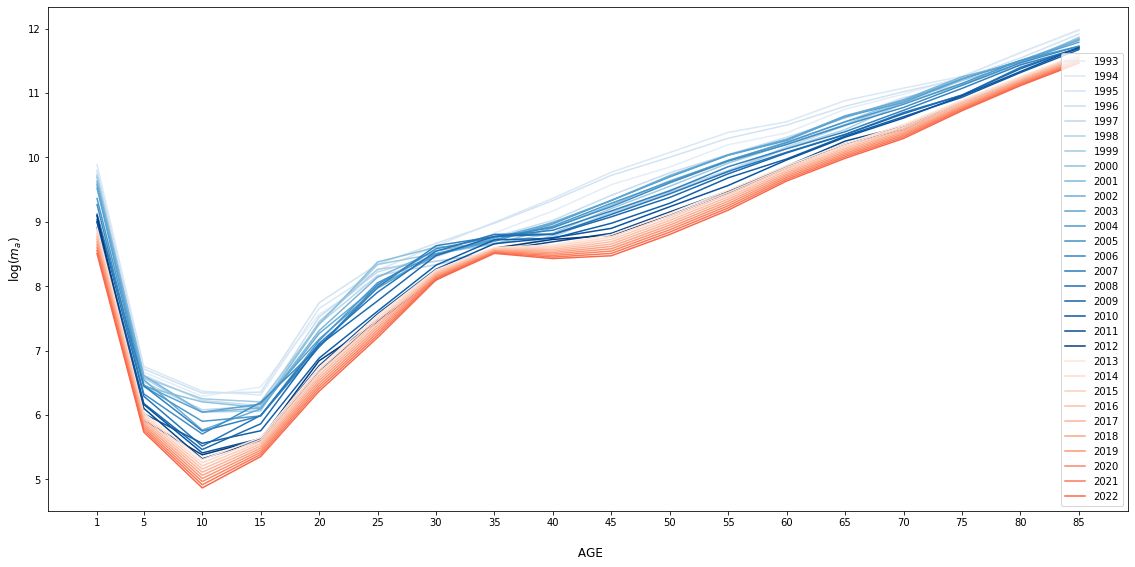

In [34]:
n = 20
color = plt.cm.Blues(np.linspace(0.1, 1,n+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig = plt.figure(figsize = (15,7))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(colormap = 'Blues')
for year in data_male.columns:
    plt.plot([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
             data_male[year],
             label = year)

      
color2 = plt.cm.Reds(np.linspace(0.1, 1,n+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color2)

ax2 = fig.add_axes([0,0,1,1])

ax2.plot(colormap = 'Reds')
for i in range(10):
    plt.plot([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
             return_initial_values_of_forecast(n_steps = i),
             label = str(2012 + i + 1),color = color2[i])
    

plt.xticks([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85])
ax.set_xlabel('\n AGE',fontsize = 12)
ax.set_ylabel('log($m_a$)',fontsize = 12)
#ax.set_title('\n Возрастные профили коэффициентов смертности \n для женщин, Москва и МО, период 1993-2014 \n', fontsize = 14)

plt.legend();




### Перевод коэффициентов в вероятности с использванием Формул Чанга



Cогласно Kanneth (см. источники), мы можем вычислить вероятности умереть в кнкретный период в кнкретной возрастной группе, используя т.н. Формулы Чанга. 
Они верны без дополнительных манипуляций для "средних" возрастных групп, однако требуют осбого подхода для первых двух и псоследней


$$ _nq_x = \dfrac{n _nM_x}{1 + (n - _na_x)\cdot_nM_x}$$

Здесь $n$ - интервал возрастных групп

$_na_x$ - среднее число лет, прожитое в заданном интервале взрастной группы теми, кто умер, который для всех обычных групп пложим равным $\dfrac{n}{2}$

$_nM_x$ - показатель, рассчитанный и предсказанный выше (отнормированный на 1 000 000 человек)

В качестве примера рассчитаем вероятности для мужчин в 2011 году, все операции производим поэлементно


$$ _1a_0 = 0.07 + 1.7*(_1M_0)$$

$$ _4a_1 = 1.5 $$

$$ _{\infty}a_{85} = \dfrac{1}{_\infty M_{85}}$$

In [35]:
def calculate_q(data_vec):
    
    M = (np.exp(np.array(data_vec)))/1000000
    n = np.array([1] + [5 for i in range(17)])
    a = np.array([M[0]*1.7 + 0.07] + [1.5] + [2.5 for i in range(15)] + [1/M[-1]])

    up = n*M
    down = np.ones(18) + (n - a)*M

    return np.round(up/down,4)

In [36]:
data_male[2011]

Drac0      8.910856
Drac1      6.103677
Drac5      5.320568
Drac10     5.607639
Drac15     6.690842
Drac20     7.470224
Drac25     8.098187
Drac30     8.551401
Drac35     8.689717
Drac40     8.820921
Drac45     9.152817
Drac50     9.478840
Drac55     9.863551
Drac60    10.252999
Drac65    10.482205
Drac70    10.857334
Drac75    11.201531
Drac80    11.595293
Name: 2011, dtype: float64

In [37]:
calculate_q(pd.Series(return_initial_values_of_forecast(n_steps = 1).ravel()))

array([0.007 , 0.002 , 0.001 , 0.0014, 0.0041, 0.0091, 0.0187, 0.0266,
       0.0272, 0.0315, 0.0436, 0.0619, 0.09  , 0.1245, 0.1645, 0.2325,
       0.3193, 1.    ])

In [38]:
def probability_forecast():
    results = []
    for i in range(10):
        results.append(calculate_q(pd.Series(return_initial_values_of_forecast(n_steps = i).ravel())))
    return results

In [39]:
results = probability_forecast()
results = pd.DataFrame(results).T
results.columns = [2013 + i for i in range(10)]

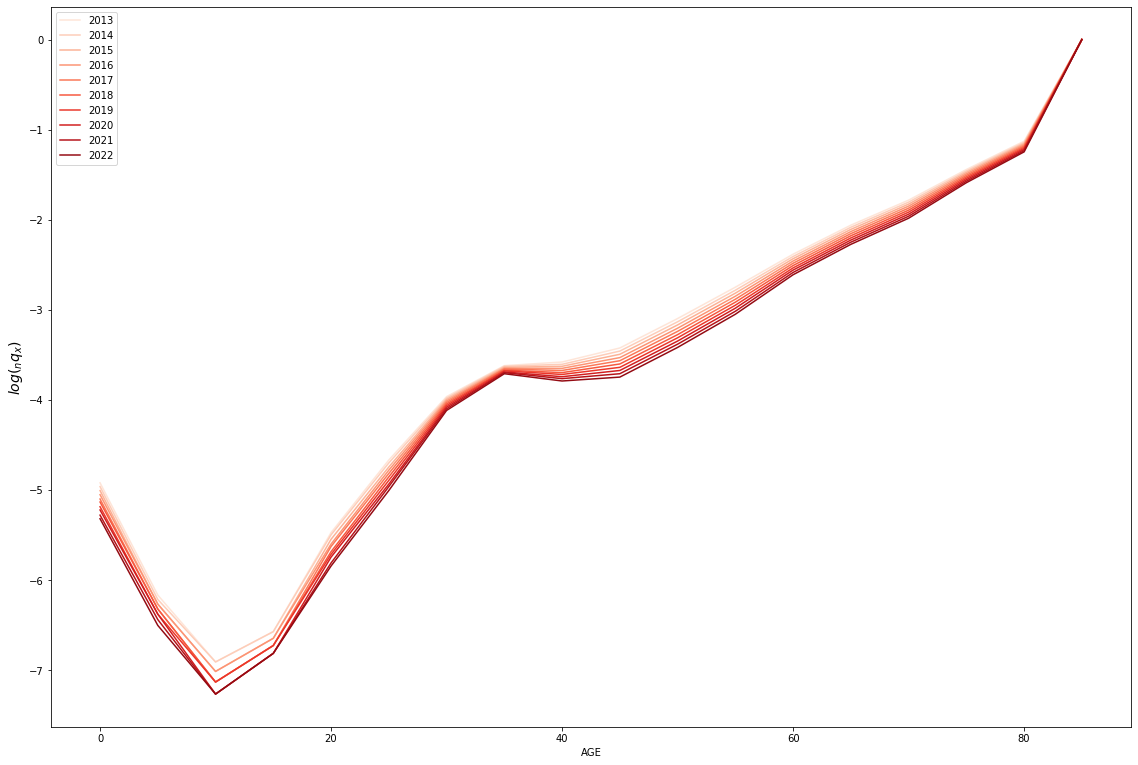

In [40]:
s = 10 
color2 = plt.cm.Reds(np.linspace(0.1, 1,s+1))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color2)

fig = plt.figure(figsize = (15,10))
ax = fig.add_axes([0,0,1,1])

cnt = 0
for i in results.columns:
    ax.plot([5*i for i in range(18)],
            np.log(results[i]),label = str(2013+cnt))
    cnt+=1
ax.set_ylabel('$log(_nq_x)$',fontsize = 14)
ax.set_xlabel('AGE')
plt.legend()

plt.savefig('probabilities_prediction.png')

In [41]:
calculate_q(data_male[2011])

array([0.0074, 0.0022, 0.001 , 0.0014, 0.004 , 0.0087, 0.0163, 0.0255,
       0.0293, 0.0333, 0.0461, 0.0633, 0.0917, 0.1324, 0.1638, 0.2297,
       0.3095, 1.    ])

In [42]:
starts = [0,1] + [5*i for i in range(1,17)]
finishes = [1,5] + [5*i for i in range(2,18)]
results['start'] = pd.Series(starts)
results['finish'] = pd.Series(finishes)
results.head()


,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,start,finish
0,0.0073,0.0070,0.0067,0.0064,0.0061,0.0059,0.0056,0.0054,0.0051,0.0049,0,1
1,0.0021,0.0020,0.0019,0.0019,0.0018,0.0018,0.0017,0.0017,0.0016,0.0015,1,5
2,0.0010,0.0010,0.0009,0.0009,0.0008,0.0008,0.0008,0.0007,0.0007,0.0007,5,10
3,0.0014,0.0014,0.0013,0.0013,0.0012,0.0012,0.0012,0.0011,0.0011,0.0011,10,15
4,0.0042,0.0041,0.0039,0.0037,0.0036,0.0034,0.0033,0.0032,0.0030,0.0029,15,20


In [43]:
'''
Также добавим 2011 и 2012 годы для зашивки в модель

'''

results[2011] = calculate_q(data_male[2011])
results[2012] = calculate_q(data_male[2012])

results.head()

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,start,finish,2011,2012
0,0.0073,0.0070,0.0067,0.0064,0.0061,0.0059,0.0056,0.0054,0.0051,0.0049,0,1,0.0074,0.0088
1,0.0021,0.0020,0.0019,0.0019,0.0018,0.0018,0.0017,0.0017,0.0016,0.0015,1,5,0.0022,0.0019
2,0.0010,0.0010,0.0009,0.0009,0.0008,0.0008,0.0008,0.0007,0.0007,0.0007,5,10,0.0010,0.0011
3,0.0014,0.0014,0.0013,0.0013,0.0012,0.0012,0.0012,0.0011,0.0011,0.0011,10,15,0.0014,0.0014
4,0.0042,0.0041,0.0039,0.0037,0.0036,0.0034,0.0033,0.0032,0.0030,0.0029,15,20,0.0040,0.0047


In [44]:
results.to_csv('results_men.csv')